## Attempt at LSH

Notebok inspired by:
https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/

### Generate a list of shingles from the complete set of ALL text in the database!

In [33]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def getQuery(query, columns):
    conn = sqlite3.connect("joke2.db")
    cur = conn.cursor()
    cur.execute(query) 
    rows = pd.DataFrame(cur.fetchall(), columns=columns, )
    conn.close()
    return(rows)

In [7]:
tmp = getQuery("SELECT nice_title, nice_body FROM jokes;", columns=["Title","Body"])

In [8]:
len(tmp)

801956

In [19]:
all_words = {}
for index, row in tmp.iterrows():
    for tword in row["Title"].split():
        if tword not in all_words:
            all_words[tword] = 0
        all_words[tword] += 1
        
    for tword in row["Body"].split():
        if tword not in all_words:
            all_words[tword] = 0
        all_words[tword] += 1

In [21]:
len(all_words)

193542

In [25]:
# checkpoint save
df = pd.DataFrame.from_dict(all_words, orient='index', columns=["occur"])

In [30]:
df.to_csv("shingles.csv")

In [31]:
df.sort_values(by="occur", ascending=False).head(5)

occur
the  1533670
a    1037205
and   708726
to    661361
i     513790

In [42]:
df.plot()
plt.yscale("log")

### Determining occurence range

The most commonly occuring words are not very informative, and the least occuring also not. We need a good range of informative shingles. However, we can't do this for the map given above because this counts the same word twice if it appears twice in the same articles.

So what we really need is to count each word once if it appears at all in a given article.

In [45]:
df[df["occur"] < 80000].sort_values(by="occur", ascending=False).head(5)

occur
just   79230
about  78552
get    77990
as     77859
into   77558

In [47]:
all_words2 = {}
for index, row in tmp.iterrows():
    for tword in set(row["Title"].split() + row["Body"].split()):
        if tword not in all_words2:
            all_words2[tword] = 0
        all_words2[tword] += 1  


In [48]:
len(all_words2)

193542

In [49]:
# Same number of words before, but different frequencies hopefully
# checkpoint save
df = pd.DataFrame.from_dict(all_words2, orient='index', columns=["occur"])
df.to_csv("shingles.better.csv")

In [50]:
df.sort_values(by="occur", ascending=False).head(5)

occur
a    427603
the  391889
to   270336
i    242922
and  241038

In [51]:
df.plot()
plt.yscale("log")

We have 800k jokes, so we should look for words that occur in about 400k them...?

In [56]:
df[df["occur"] < 100].sort_values(by="occur", ascending=False).head(5)

occur
veterans      99
directors     99
lunches       99
cleavage      99
blamed        99

## What about Bigrams or Trigrams?

Ideally we want the frequency of our shingles to be relatively low compared to the sets. We can try tuples of words for this, and this would give our shingles more merit. However, short jokes (< 3 words, which are surprisingly common) would be missed.

 * 3-word shingles by default
 * If a joke has less than this, then we use a bigram or a unigram and exclude any shingles that contain subset shingles.

In [57]:
all_3words = {}
all_2words = {}
all_1words = {}

# Get set of 3-wordmers for each row
for index, row in tmp.iterrows():   
    words_in_order = row["Title"].split() + row["Body"].split()
    lword = len(words_in_order)
    
    if  lword >= 3:
        mers3 = [words_in_order[x:x+3] for x in range(len(words_in_order)-2)]
        for i,word3 in enumerate(mers3):
            if word3 not in mers3[i+1:]:
                # unique 3-mer
                words = " ".join(word3)
                if words not in all_3words:
                    all_3words[words] = 0
                all_3words[words] += 1  
            
    elif lword == 2:
        words = " ".join(words_in_order)
        if words not in all_2words:
            all_2words[words] = 0
        all_2words[words] += 1  
        
    elif lword == 1:
        words = words_in_order[0]
        if words not in all_1words:
            all_1words[words] = 0
        all_1words[words] += 1

In [58]:
len(all_3words)

9290770

In [59]:
len(all_2words)

3883

In [60]:
len(all_1words)

24

In [63]:
all_1words

{'tldr': 1,
 'none': 363,
 'httpwwwyoutubetobcom2014061362014spainvsnetherlandshtml': 1,
 '2': 1,
 'timing': 1,
 'politics': 1,
 'redditcom': 1,
 'song': 1,
 'deleted': 15,
 '17': 1,
 'vegans': 1,
 'chameleon': 2,
 'me': 2,
 '2537': 1,
 'httpsyoutubeer5evsghhdihttpsyoutubeer5evsghhdi': 1,
 'httpsyoutubejtvnnjy4tohttpsyoutubejtvnnjy4to': 1,
 'httpsyoutubebjftjzsars8httpsyoutubebjftjzsars8': 1,
 'httpsyoutube6tvivcsg8httpsyoutube6tvivcsg8': 1,
 'httpsyoutube2rjbxoqctcmhttpsyoutube2rjbxoqctcm': 1,
 'httpsyoutube0vwneearpouhttpsyoutube0vwneearpou': 1,
 'httpsyoutubecjmsjjot3khttpsyoutubecjmsjjot3k': 1,
 'httpsyoutubebk9e3pws2a8httpsyoutubebk9e3pws2a8': 1,
 'httpsyoutubenwjwj1nc9chttpsyoutubenwjwj1nc9c': 1,
 'the': 1}

* Most of these 1words can be ignored, the most common being "none" only in 363 jokes and being a representation of a missing joke.

In [65]:
w2 = pd.DataFrame.from_dict(all_2words, orient='index', columns=["occur"])

In [68]:
w2.sort_values(by="occur", ascending=False)

occur
v none                                      474
504323 none                                 240
joke none                                   114
me none                                      93
ea none                                      92
feminism none                                83
you none                                     79
rjokes none                                  76
jokes none                                   70
28 none                                      63
trump none                                   62
hi none                                      56
reddit none                                  50
2016 none                                    44
america none                                 38
lol none                                     36
v deleted                                    33
life none                                    32
funny none                                   28
test none                                    25
504324 none                                  24
repost none                                  24
hello none                                   23
test deleted                                 23
rthedonald none                              22
c none                                       19
joke deleted                                 19
h none                                       18
deleted none                                 17
removed none                                 17
...                                         ...
makeamericavoteagain none                     1
b00bs none                                    1
httpswwwyoutubecomwatchvrwgcfpaj8xq none      1
136000 none                                   1
786 none                                      1
feminists deleted                             1
httpswwwcontrisharecommik0 none               1
httpswwwcontrisharecomluld none               1
204039582309 deleted                          1
httpswwwcontrisharecomm07k none               1
httpswwwcontrisharecomm7hj none               1
httpswwwcontrisharecomm8he none               1
httpswwwcontrisharecomm8hi none               1
httpswwwcontrisharecomm9dw none               1
dank none                                     1
cancer none                                   1
httpswwwcontrisharecommh90 none               1
httpswwwcontrisharecommkn2 none               1
harambe deleted                               1
democracy none                                1
hhn none                                      1
imwithstupid none                             1
rall none                                     1
a merica                                      1
work none                                     1
pranked none                                  1
republicans none                              1
119 deleted                                   1
dnc none                                      1
joke joke                                     1

[3883 rows x 1 columns]

* It looks like most of these are just title jokes with an empty body. Let's convert these to one-word titles.

In [76]:
w2.index = [x.replace("none","").replace("deleted","") for x in w2.index]

In [79]:
w2.sort_values(by="occur", ascending=False)

occur
v                                       474
504323                                  240
joke                                    114
me                                       93
ea                                       92
feminism                                 83
you                                      79
rjokes                                   76
jokes                                    70
28                                       63
trump                                    62
hi                                       56
reddit                                   50
2016                                     44
america                                  38
lol                                      36
v                                        33
life                                     32
funny                                    28
test                                     25
504324                                   24
repost                                   24
hello                                    23
test                                     23
rthedonald                               22
c                                        19
joke                                     19
h                                        18
                                         17
removed                                  17
...                                     ...
makeamericavoteagain                      1
b00bs                                     1
httpswwwyoutubecomwatchvrwgcfpaj8xq       1
136000                                    1
786                                       1
feminists                                 1
httpswwwcontrisharecommik0                1
httpswwwcontrisharecomluld                1
204039582309                              1
httpswwwcontrisharecomm07k                1
httpswwwcontrisharecomm7hj                1
httpswwwcontrisharecomm8he                1
httpswwwcontrisharecomm8hi                1
httpswwwcontrisharecomm9dw                1
dank                                      1
cancer                                    1
httpswwwcontrisharecommh90                1
httpswwwcontrisharecommkn2                1
harambe                                   1
democracy                                 1
hhn                                       1
imwithstupid                              1
rall                                      1
a merica                                  1
work                                      1
pranked                                   1
republicans                               1
119                                       1
dnc                                       1
joke joke                                 1

[3883 rows x 1 columns]

It doesn't look like these 2words are very useful. They only describe a handful of jokes...
Let's have a look at the 3words

In [80]:
w3 = pd.DataFrame.from_dict(all_3words, orient='index', columns=["occur"])

In [82]:
w3.sort_values(by="occur", ascending=False)

occur
what do you             46228
do you call             36288
you call a              25026
the difference between  20108
into a bar              17227
whats the difference    16684
walks into a            16096
how do you              14625
what did the            12871
why did the             11917
difference between a    10187
did you hear             9485
out of the               8326
you hear about           7492
what is the              7244
hear about the           7199
i dont know              7138
have in common           6922
does it take             6720
it take to               6544
do you know              6191
say to the               6184
one of the               5816
do you get               5709
walk into a              5420
i have a                 5283
man walks into           5224
to the other             5117
the next day             5042
up to the                4929
...                       ...
homework i forgot           1
like a cheetos              1
cheetos haha so             1
attic and when              1
rabbi basic none            1
their attic and             1
lamp in their               1
couple come across          1
old couple come             1
couldnt put tu              1
ballerinas wear but         1
what ballerinas wear        1
me what ballerinas          1
wipes out deleted           1
man wipes out               1
fat man wipes               1
the rabbi basic             1
haha so small               1
wasnt the rabbi             1
quite saturated d           1
is quite saturated          1
market is quite             1
guess that market           1
bottled water but           1
considered creating a       1
i considered creating       1
so so salty                 1
no so so                    1
small no so                 1
is joe joe                  1

[9290770 rows x 1 columns]

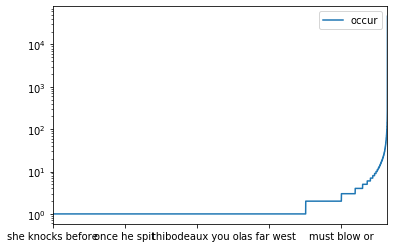

In [86]:
w3.sort_values(by="occur").plot()
plt.yscale("log")

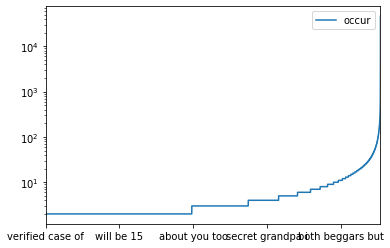

In [91]:
w3_gt1 = (w3[w3["occur"] > 1])
w3_gt1.sort_values(by="occur").plot()
plt.yscale("log")

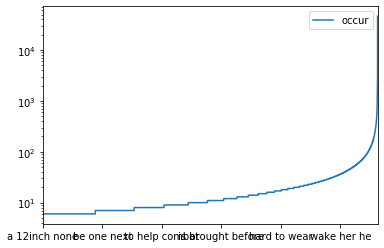

In [97]:
w3_gt5 = w3[w3["occur"] > 5]
w3_gt5.sort_values(by="occur").plot()
plt.yscale("log")

In [99]:
len(w3_gt5)

562542

We won't capture all posts, but this should be enough to get a diverse enough list (hopefully)

------

"When looking for the proper number of shingles, take a look at the average number of characters or tokens that appear in your documents. Make sure that you choose enough shingles such that there will be significantly more shingles than the average number of shingles in your document." 

### Let's use single word shingles, but filter nonsense words

In [103]:
df = pd.DataFrame.from_csv("shingles.better.csv")

/home/tetris/miniconda3/envs/jokedict/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [107]:
len(df)

193542

How many keys do we lose if we define lower-limits on repostability?

In [134]:
keys_left = pd.DataFrame(columns=["NumKeys", "MoreThan"])

for x in list(range(1,11)) + list(range(20,110,10)): # + list(range(100,1100,100)):
    keys_left = keys_left.append({"NumKeys" : len(df[df["occur"] > x]), "MoreThan":x}, ignore_index=True)

(0, 10)

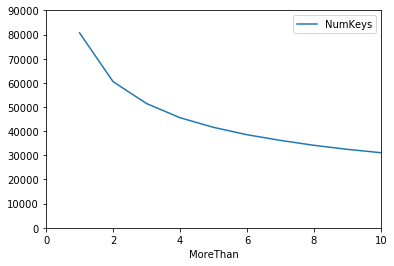

In [137]:
keys_left.plot(y="NumKeys", x="MoreThan")
plt.ylim(0,90000)
plt.xlim(0,10)
#plt.yscale("log")

Above 5 seems agreeable.